LIMPAR PIB SPRINT 2

 preparar e organizar os dados do PIB:
  1. -Primeiro, ele carrega o arquivo original, que vem separado por ponto e vírgula (;).
  2. -Em seguida, ignora as linhas de cabeçalho, garantindo que apenas os dados realmente úteis sejam lidos.
  3. -Depois, filtra as informações para manter somente os municípios do Ceará — identificados pelo código IBGE que começa com 23.
  4. -As colunas são renomeadas, deixando os nomes mais padronizados e fáceis de entender.
  5. -O nome de cada município também é ajustado, removendo a sigla do estado (por exemplo: transformando “Fortaleza (CE)” apenas em “Fortaleza”).
  6. -A coluna com os valores do PIB é então convertida para formato numérico, evitando problemas de cálculo.

  Por fim, o resultado limpo e organizado é salvo em um novo arquivo CSV, pronto para ser usado em análises.

In [ ]:
import pandas as pd
import chardet


def limpar_dados_pib(caminho_arquivo_bruto='pib_municipios.csv', caminho_saida_csv='pib_municipios_ce_limpo.csv'):

    print(f"Iniciando a limpeza do arquivo: {caminho_arquivo_bruto}")

    try:

        with open(caminho_arquivo_bruto, 'rb') as f:
            result = chardet.detect(f.read(50000))
            encoding_detectada = result['encoding']
            print(f"Codificação detectada: {encoding_detectada}")

        nomes_colunas = ['codigo_ibge', 'municipio_uf', 'pib_total']


        df = pd.read_csv(
            caminho_arquivo_bruto,
            sep=';',
            header=None,
            names=nomes_colunas,
            encoding=encoding_detectada,
            skiprows=4
        )
        print(f"Arquivo carregado com sucesso. {len(df)} registros encontrados.")

        df['codigo_ibge'] = df['codigo_ibge'].astype(str)


        df_ceara = df[df['codigo_ibge'].str.startswith('23')].copy()

        if df_ceara.empty:
            print("\nATENÇÃO: Nenhum dado para municípios do Ceará (código iniciando com '23') foi encontrado.")
            return

        print(f"Registros filtrados para o Ceará. {len(df_ceara)} municípios encontrados.")
        df_ceara['municipio'] = df_ceara['municipio_uf'].str.replace(r'\s*\([A-Z]{2}\)$', '', regex=True)
        df_ceara['pib_total'] = pd.to_numeric(df_ceara['pib_total'], errors='coerce')
        df_final = df_ceara[['codigo_ibge', 'municipio', 'pib_total']]
        df_final.to_csv(caminho_saida_csv, index=False, encoding='utf-8')
        print("-" * 50)
        print(f"Processo concluído com sucesso!")
        print(f"Arquivo limpo salvo em: '{caminho_saida_csv}'")
        print("-" * 50)
        print("\nAmostra dos dados limpos:")
        print(df_final.head())

    except FileNotFoundError:
        print(f"ERRO: O arquivo '{caminho_arquivo_bruto}' não foi encontrado.")
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")

if __name__ == '__main__':
    limpar_dados_pib()


Iniciando a limpeza do arquivo: pib_municipios.csv
Codificação detectada: UTF-8-SIG
Arquivo carregado com sucesso. 5582 registros encontrados.
Registros filtrados para o Ceará. 184 municípios encontrados.
--------------------------------------------------
Processo concluído com sucesso!
Arquivo limpo salvo em: 'pib_municipios_ce_limpo.csv'
--------------------------------------------------

Amostra dos dados limpos:
    codigo_ibge municipio  pib_total
891     2300101   Abaiara   117971.0
892     2300150   Acarape   179994.0
893     2300200    Acaraú  1020201.0
894     2300309  Acopiara   564520.0
895     2300408    Aiuaba   151596.0


LIMPAR VACINA  SPRINT 2




limpeza e preparação dos dados de vacinação:

1. -Carrega o arquivo JSON com todos os registros de vacinação.
2. -Mantém apenas os pacientes que moram no Ceará, descartando os demais.
3. -Filtra o público infantil, considerando apenas crianças de até 2 anos de idade.
4. -Seleciona as colunas mais relevantes e dá nomes mais claros a elas.
5. -Ajusta os tipos de dados, transformando textos em datas ou números quando necessário.
6. -Registra os desafios encontrados, como casos em que a informação de localidade estava faltando.

Por fim, o resultado limpo e organizado é salvo em um novo arquivo CSV, pronto para ser usado em análises.




versao com muitos dias

In [ ]:
import pandas as pd
import glob
import os

def limpar_multiplos_arquivos_vacinacao(caminho_pasta='.', caminho_saida_csv='vacinacao_ce_infantil_limpo.csv'):

    print(f"Iniciando a busca por arquivos de vacinação na pasta: '{os.path.abspath(caminho_pasta)}'")

    try:

        padrao_arquivos = os.path.join(caminho_pasta, 'vacinacao*.json')
        lista_arquivos_json = glob.glob(padrao_arquivos)

        if not lista_arquivos_json:
            print(f"ERRO: Nenhum arquivo JSON com o padrão 'vacinacao*.json' foi encontrado na pasta.")
            print("Por favor, certifique-se de que os arquivos de dados estão na mesma pasta que o script.")
            return

        print(f"Encontrados {len(lista_arquivos_json)} arquivos para processar:")
        for arquivo in lista_arquivos_json:
            print(f" - {os.path.basename(arquivo)}")


        lista_dfs = [pd.read_json(arquivo) for arquivo in lista_arquivos_json]
        df = pd.concat(lista_dfs, ignore_index=True)
        print(f"\nArquivos unificados com sucesso. {len(df)} registros totais encontrados.")
        registros_sem_uf = df['sg_uf_paciente'].isnull().sum()
        print(f"Desafio: {registros_sem_uf} registros não possuem UF do paciente e serão descartados.")
        df.dropna(subset=['sg_uf_paciente'], inplace=True)
        df_ceara = df[df['sg_uf_paciente'] == 'CE'].copy()

        if df_ceara.empty:
            print("\nATENÇÃO: Nenhum registro de paciente residente no Ceará ('CE') foi encontrado nos arquivos.")
            return

        print(f"Filtro aplicado. {len(df_ceara)} registros de pacientes do Ceará encontrados.")
        df_ceara['nu_idade_paciente'] = pd.to_numeric(df_ceara['nu_idade_paciente'], errors='coerce')
        df_ceara.dropna(subset=['nu_idade_paciente'], inplace=True)
        df_infantil = df_ceara[df_ceara['nu_idade_paciente'] <= 2].copy()
        print(f"Filtro infantil (<= 2 anos) aplicado. {len(df_infantil)} registros restantes.")

        colunas_interesse = {
            'co_municipio_paciente': 'codigo_ibge',
            'no_municipio_paciente': 'municipio',
            'dt_vacina': 'data_vacinacao',
            'sg_vacina': 'sigla_vacina',
            'ds_dose_vacina': 'dose_vacina',
            'nu_idade_paciente': 'idade_paciente'
        }
        df_final = df_infantil[list(colunas_interesse.keys())].copy()
        df_final.rename(columns=colunas_interesse, inplace=True)
        df_final['data_vacinacao'] = pd.to_datetime(df_final['data_vacinacao'], errors='coerce')
        df_final['codigo_ibge'] = df_final['codigo_ibge'].astype(str).str.replace(r'\.0$', '', regex=True)
        df_final.dropna(subset=['codigo_ibge', 'data_vacinacao'], inplace=True)
        print("Colunas selecionadas, renomeadas e tipos de dados ajustados.")
        df_final.to_csv(caminho_saida_csv, index=False, encoding='utf-8')
        print("-" * 50)
        print(f"Processo concluído com sucesso!")
        print(f"Arquivo consolidado e limpo salvo em: '{caminho_saida_csv}'")
        print(f"Total de registros de vacinação infantil no Ceará processados: {len(df_final)}")
        print("-" * 50)
        print("\nAmostra dos dados limpos:")
        print(df_final.head())

    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")


if __name__ == '__main__':
    limpar_multiplos_arquivos_vacinacao()


Iniciando a busca por arquivos de vacinação na pasta: '/content'
Encontrados 3 arquivos para processar:
 - vacinacao_abr_2024_00028.json
 - vacinacao_abr_2024_00030.json
 - vacinacao_abr_2024_00029.json

Arquivos unificados com sucesso. 844713 registros totais encontrados.
Desafio: 11327 registros não possuem UF do paciente e serão descartados.
Filtro aplicado. 39810 registros de pacientes do Ceará encontrados.
Filtro infantil (<= 2 anos) aplicado. 12379 registros restantes.
Colunas selecionadas, renomeadas e tipos de dados ajustados.
--------------------------------------------------
Processo concluído com sucesso!
Arquivo consolidado e limpo salvo em: 'vacinacao_ce_infantil_limpo.csv'
Total de registros de vacinação infantil no Ceará processados: 12379
--------------------------------------------------

Amostra dos dados limpos:
   codigo_ibge                municipio data_vacinacao sigla_vacina  \
15      230075                 AMONTADA     2024-04-25         SCRV   
17      230960 

ANALISE SPRINT 2
1. -Carrega o arquivo CSV com as informações organizadas previamente.
2. -Calcula estatísticas descritivas, como contagens, médias e outras medidas que ajudam a entender o perfil geral dos dados.
3. -Cria as primeiras visualizações exploratórias, que permitem enxergar padrões de forma mais clara. Entre elas:
4. -Um gráfico de barras mostrando os 10 municípios com maior número de registros de vacinação.
5. -Um gráfico de barras com as vacinas mais aplicadas.
6. -Um histograma mostrando a distribuição da idade dos pacientes.
7. -Um gráfico de barras relacionando as vacinas aplicadas nos 5 municípios mais relevantes.
8. -Um gráfico de barras destacando os 5 municípios com menos registros de vacinação.


Iniciando a análise exploratória do arquivo: vacinacao_ce_infantil_limpo.csv
Arquivo carregado com sucesso. 12379 registros para análise.

 PASSO 1: ESTATÍSTICAS DESCRITIVAS

--- Top 10 Municípios com mais registros de vacinação ---
municipio
FORTALEZA            2086
CAUCAIA               594
JUAZEIRO DO NORTE     481
SOBRAL                441
MARACANAU             425
TIANGUA               243
CRATO                 220
ITAPIPOCA             200
EUSEBIO               199
CANINDE               173
Name: count, dtype: int64

--- 5 Municípios com menos registros de vacinação ---
municipio
BAIXIO                   4
PALMACIA                 4
IBICUITINGA              2
SAO JOAO DO JAGUARIBE    2
JATI                     1
Name: count, dtype: int64

--- Contagem por tipo de vacina ---
sigla_vacina
MenACWY                                                   5546
HepB                                                      3232
HepAinf                                                    869
SCRV  

/tmp/ipython-input-1543256887.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contagem_municipios.head(10).values, y=contagem_municipios.head(10).index, palette='viridis')



Gráfico 1 salvo como: 'grafico_top10_municipios.png'


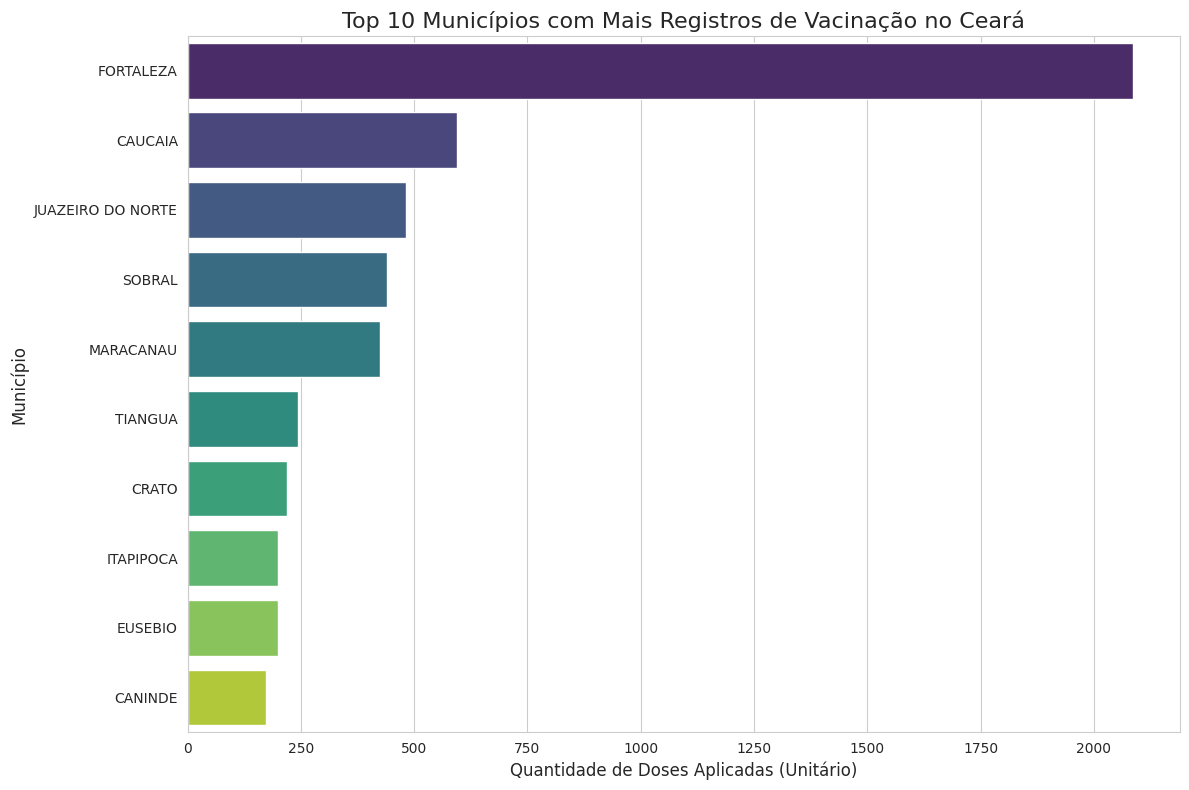

/tmp/ipython-input-1543256887.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contagem_vacinas.values, y=contagem_vacinas.index, palette='plasma')


Gráfico 2 salvo como: 'grafico_distribuicao_vacinas.png'


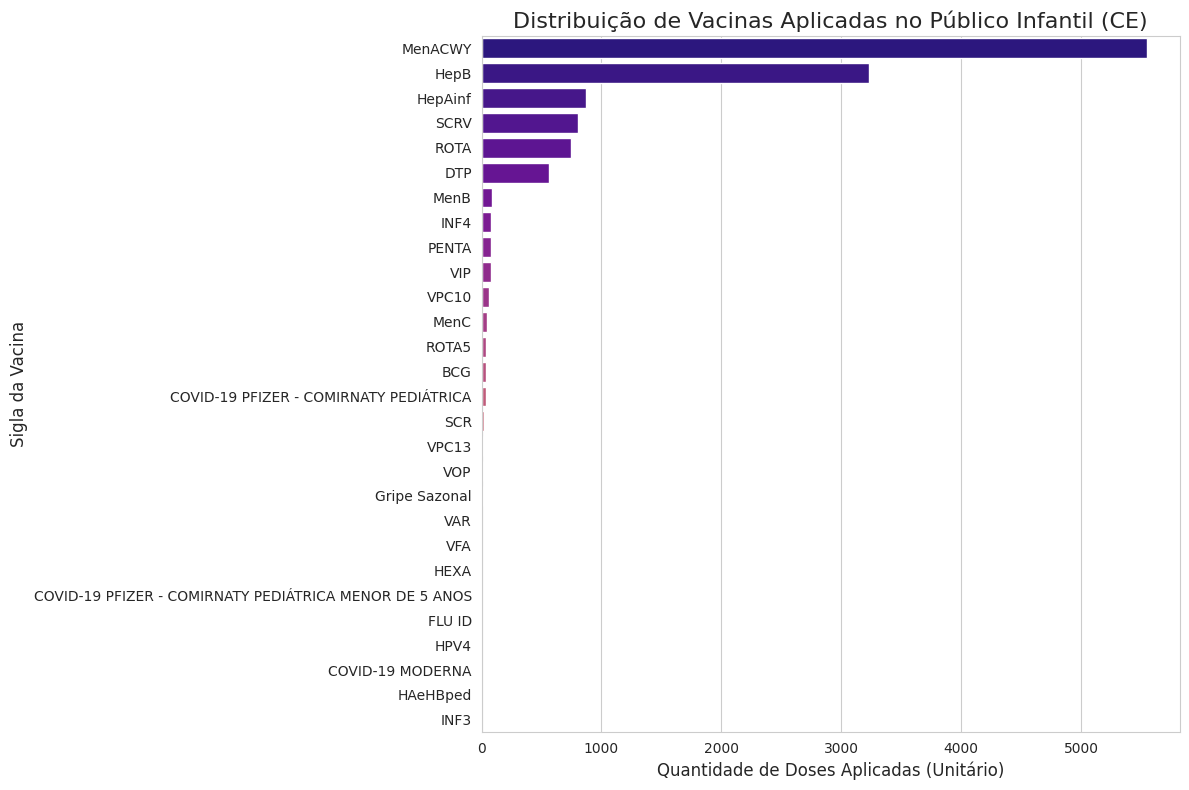

Gráfico 3 salvo como: 'grafico_distribuicao_idade.png'


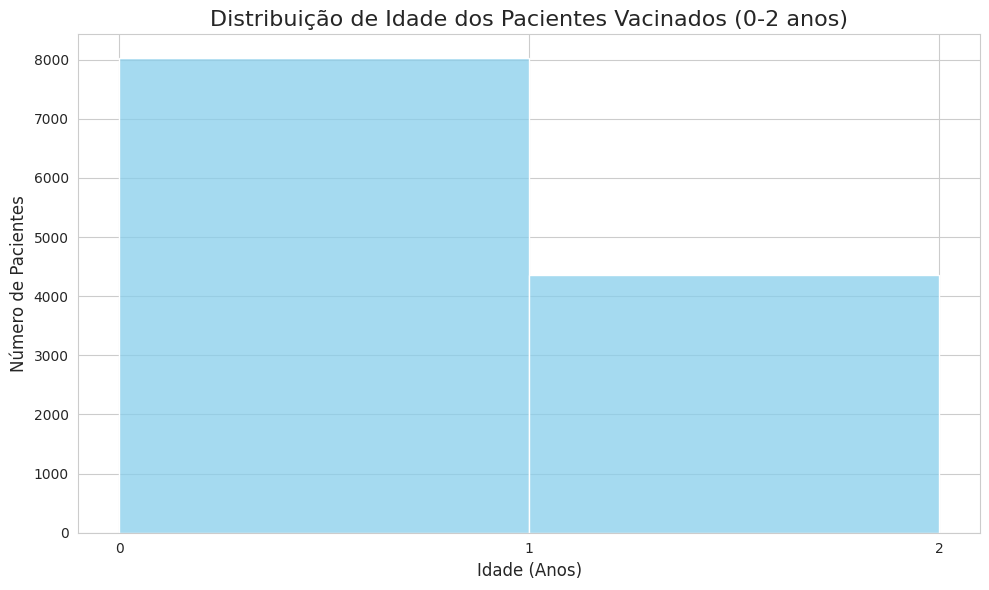

Gráfico 4 salvo como: 'grafico_vacinas_por_municipio_top5.png'


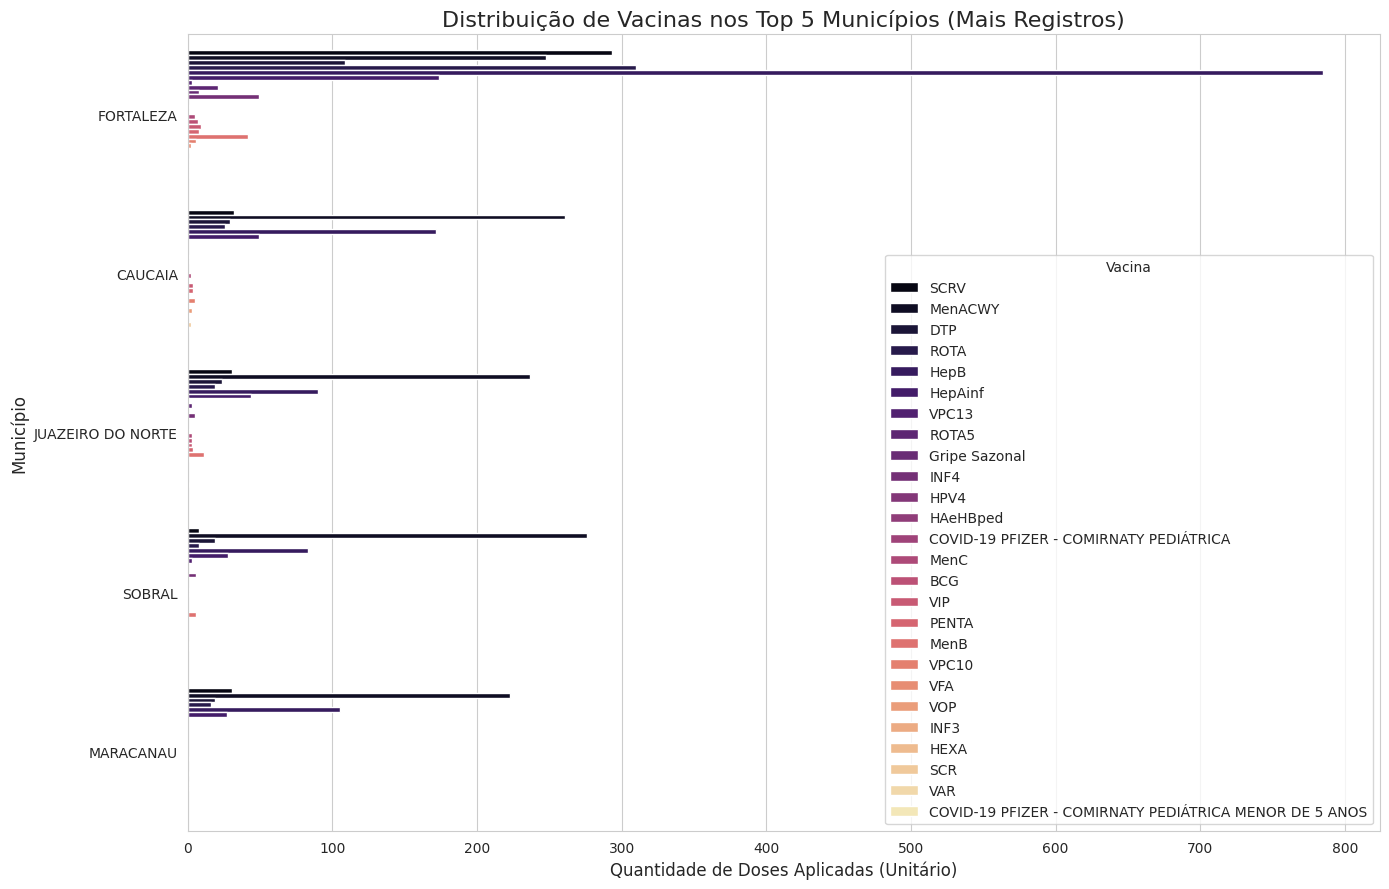

/tmp/ipython-input-1543256887.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bottom_5_municipios.sort_values(ascending=True).values, y=bottom_5_municipios.sort_values(ascending=True).index, palette='rocket')


Gráfico 5 salvo como: 'grafico_bottom5_municipios.png'


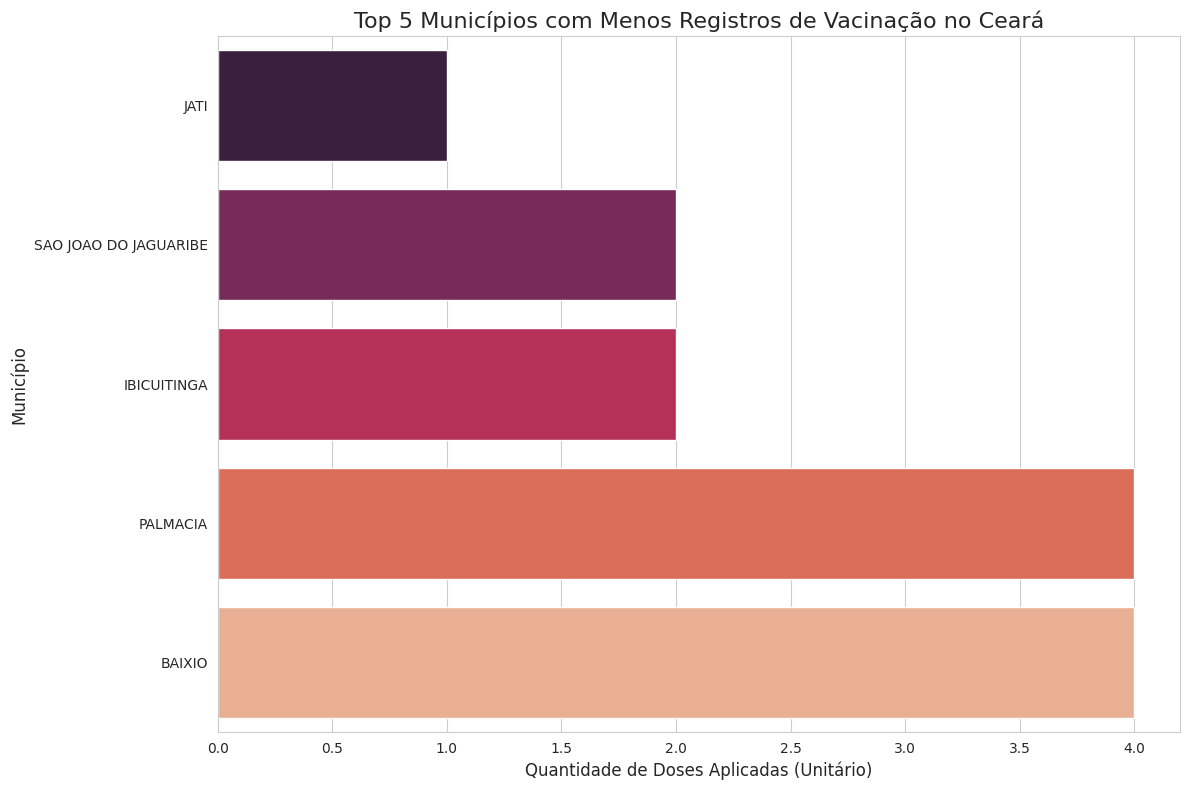


Análise exploratória concluída com sucesso!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analise_exploratoria(caminho_csv='vacinacao_ce_infantil_limpo.csv'):

    print(f"Iniciando a análise exploratória do arquivo: {caminho_csv}")

    try:

        df = pd.read_csv(caminho_csv)
        print(f"Arquivo carregado com sucesso. {len(df)} registros para análise.")
        df['data_vacinacao'] = pd.to_datetime(df['data_vacinacao'])

        print("\n" + "="*50)
        print(" PASSO 1: ESTATÍSTICAS DESCRITIVAS")
        print("="*50)

        contagem_municipios = df['municipio'].value_counts()
        print("\n--- Top 10 Municípios com mais registros de vacinação ---")
        print(contagem_municipios.head(10))
        print("\n--- 5 Municípios com menos registros de vacinação ---")
        print(contagem_municipios.tail(5))
        contagem_vacinas = df['sigla_vacina'].value_counts()
        print("\n--- Contagem por tipo de vacina ---")
        print(contagem_vacinas)
        print("\n--- Estatísticas da idade dos pacientes (em anos) ---")
        print(df['idade_paciente'].describe())
        print("\n" + "="*50)
        print(" PASSO 2: VISUALIZAÇÕES EXPLORATÓRIAS")
        print("="*50)


        sns.set_style("whitegrid")
        plt.figure(figsize=(12, 8))
        sns.barplot(x=contagem_municipios.head(10).values, y=contagem_municipios.head(10).index, palette='viridis')
        plt.title('Top 10 Municípios com Mais Registros de Vacinação no Ceará', fontsize=16)
        plt.xlabel('Quantidade de Doses Aplicadas (Unitário)', fontsize=12)
        plt.ylabel('Município', fontsize=12)
        plt.tight_layout()
        nome_arquivo_grafico1 = 'grafico_top10_municipios.png'
        plt.savefig(nome_arquivo_grafico1)
        print(f"\nGráfico 1 salvo como: '{nome_arquivo_grafico1}'")
        plt.show()


        plt.figure(figsize=(12, 8))
        sns.barplot(x=contagem_vacinas.values, y=contagem_vacinas.index, palette='plasma')
        plt.title('Distribuição de Vacinas Aplicadas no Público Infantil (CE)', fontsize=16)
        plt.xlabel('Quantidade de Doses Aplicadas (Unitário)', fontsize=12)
        plt.ylabel('Sigla da Vacina', fontsize=12)
        plt.tight_layout()
        nome_arquivo_grafico2 = 'grafico_distribuicao_vacinas.png'
        plt.savefig(nome_arquivo_grafico2)
        print(f"Gráfico 2 salvo como: '{nome_arquivo_grafico2}'")
        plt.show()


        plt.figure(figsize=(10, 6))
        sns.histplot(df['idade_paciente'], bins=[0, 1, 2], kde=False, color='skyblue')
        plt.title('Distribuição de Idade dos Pacientes Vacinados (0-2 anos)', fontsize=16)
        plt.xlabel('Idade (Anos)', fontsize=12)
        plt.ylabel('Número de Pacientes', fontsize=12)
        plt.xticks([0, 1, 2])
        plt.tight_layout()
        nome_arquivo_grafico3 = 'grafico_distribuicao_idade.png'
        plt.savefig(nome_arquivo_grafico3)
        print(f"Gráfico 3 salvo como: '{nome_arquivo_grafico3}'")
        plt.show()


        top_5_municipios = contagem_municipios.head(5).index
        df_top5 = df[df['municipio'].isin(top_5_municipios)]

        plt.figure(figsize=(14, 9))
        sns.countplot(data=df_top5, y='municipio', hue='sigla_vacina', order=top_5_municipios, palette='magma')
        plt.title('Distribuição de Vacinas nos Top 5 Municípios (Mais Registros)', fontsize=16)
        plt.xlabel('Quantidade de Doses Aplicadas (Unitário)', fontsize=12)
        plt.ylabel('Município', fontsize=12)
        plt.legend(title='Vacina')
        plt.tight_layout()
        nome_arquivo_grafico4 = 'grafico_vacinas_por_municipio_top5.png'
        plt.savefig(nome_arquivo_grafico4)
        print(f"Gráfico 4 salvo como: '{nome_arquivo_grafico4}'")
        plt.show()


        bottom_5_municipios = contagem_municipios.tail(5)

        plt.figure(figsize=(12, 8))
        sns.barplot(x=bottom_5_municipios.sort_values(ascending=True).values, y=bottom_5_municipios.sort_values(ascending=True).index, palette='rocket')
        plt.title('Top 5 Municípios com Menos Registros de Vacinação no Ceará', fontsize=16)
        plt.xlabel('Quantidade de Doses Aplicadas (Unitário)', fontsize=12)
        plt.ylabel('Município', fontsize=12)
        plt.tight_layout()
        nome_arquivo_grafico5 = 'grafico_bottom5_municipios.png'
        plt.savefig(nome_arquivo_grafico5)
        print(f"Gráfico 5 salvo como: '{nome_arquivo_grafico5}'")
        plt.show()

        print("\nAnálise exploratória concluída com sucesso!")


    except FileNotFoundError:
        print(f"ERRO: O arquivo '{caminho_csv}' não foi encontrado.")
        print("Por favor, execute o script de limpeza de vacinação primeiro para gerar este arquivo.")
    except Exception as e:
        print(f"Ocorreu um erro inesperado durante a análise: {e}")


if __name__ == '__main__':
    analise_exploratoria()



SPRINT 3

ANALISE-CORRELEACAO SPRINT 3

--- Iniciando Análise Aprofundada e Dashboard (Sprint 3) ---
--- Passo 1: Carregando e unificando dados ---
Bases de dados limpas unificadas com sucesso.
DataFrame final para análise contém 184 municípios com dados completos.

--- Passo 2: Analisando a correlação ---
Coeficiente de Correlação de Pearson entre PIB e Doses Aplicadas: 0.9574
Interpretação: Forte correlação positiva.
(Nota: Análise com números absolutos. A correlação pode mudar ao normalizar pela população.)

Gráfico de correlação salvo em: 'grafico_correlacao_pib_doses.png'


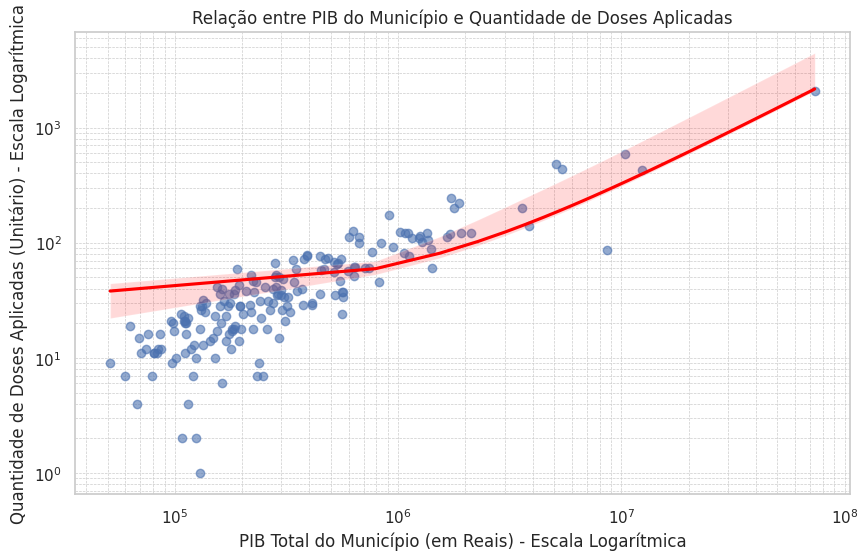


--- Passo 3: Gerando o dashboard interativo ---
Dashboard interativo salvo em: 'dashboard_interativo.html'



--- Sprint 3 concluída com sucesso! ---


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


def _carregar_e_unificar_dados(caminho_vacinacao, caminho_pib):

    print("--- Passo 1: Carregando e unificando dados ---")
    df_vac = pd.read_csv(caminho_vacinacao, dtype={'codigo_ibge': str})
    df_pib = pd.read_csv(caminho_pib, dtype={'codigo_ibge': str})

    contagem_doses = df_vac.groupby(['codigo_ibge', 'municipio']).size().reset_index(name='contagem_doses')
    contagem_doses['join_key'] = contagem_doses['codigo_ibge'].str[:6]
    df_pib['join_key'] = df_pib['codigo_ibge'].str[:6]
    df_completo = pd.merge(contagem_doses, df_pib, on='join_key', how='inner', suffixes=('_vac', '_pib'))
    df_completo.drop(columns=['municipio_pib', 'codigo_ibge_pib'], inplace=True)
    df_completo.rename(columns={'codigo_ibge_vac': 'codigo_ibge', 'municipio_vac': 'municipio'}, inplace=True)
    print("Bases de dados limpas unificadas com sucesso.")
    df_completo.dropna(subset=['pib_total', 'contagem_doses'], inplace=True)
    print(f"DataFrame final para análise contém {len(df_completo)} municípios com dados completos.")

    return df_completo

def _analisar_e_visualizar_correlacao(df_completo):

    print("\n--- Passo 2: Analisando a correlação ---")
    if df_completo.empty:
        print("DataFrame vazio, pulando análise de correlação.")
        return

    correlacao = df_completo['pib_total'].corr(df_completo['contagem_doses'])
    print(f"Coeficiente de Correlação de Pearson entre PIB e Doses Aplicadas: {correlacao:.4f}")

    if correlacao > 0.7: print("Interpretação: Forte correlação positiva.")
    elif correlacao > 0.4: print("Interpretação: Correlação positiva moderada.")
    elif correlacao > 0: print("Interpretação: Correlação positiva fraca.")
    else: print("Interpretação: Correlação negativa ou próxima de zero.")
    print("(Nota: Análise com números absolutos. A correlação pode mudar ao normalizar pela população.)")

    df_para_plot = df_completo[(df_completo['pib_total'] > 0) & (df_completo['contagem_doses'] > 0)]

    if not df_para_plot.empty:
        plt.figure(figsize=(10, 6))
        sns.regplot(data=df_para_plot, x='pib_total', y='contagem_doses', scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
        plt.title('Relação entre PIB do Município e Quantidade de Doses Aplicadas')
        plt.xlabel('PIB Total do Município (em Reais) - Escala Logarítmica')
        plt.ylabel('Quantidade de Doses Aplicadas (Unitário) - Escala Logarítmica')
        plt.xscale('log'); plt.yscale('log')
        plt.grid(True, which="both", ls="--", linewidth=0.5)
        caminho_imagem_corr = 'grafico_correlacao_pib_doses.png'
        plt.savefig(caminho_imagem_corr)
        print(f"\nGráfico de correlação salvo em: '{caminho_imagem_corr}'")
        plt.show()
        plt.close()
    else:
        print("\nAVISO: Não foi possível gerar o gráfico de correlação pois não há dados com valores positivos para ambos os eixos.")

def _gerar_dashboard_interativo(df_completo):

    print("\n--- Passo 3: Gerando o dashboard interativo ---")
    if df_completo.empty:
        print("DataFrame vazio, pulando a geração do dashboard.")
        return


    top_10_pib = df_completo.nlargest(10, 'pib_total').sort_values('pib_total', ascending=True)
    top_10_doses = df_completo.nlargest(10, 'contagem_doses').sort_values('contagem_doses', ascending=True)
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Top 10 Municípios por Maior PIB', 'Top 10 Municípios por Doses Aplicadas')
    )
    fig.add_trace(
        go.Bar(x=top_10_pib['pib_total'], y=top_10_pib['municipio'], orientation='h', name='PIB'),
        row=1, col=1
    )
    fig.add_trace(
        go.Bar(x=top_10_doses['contagem_doses'], y=top_10_doses['municipio'], orientation='h', name='Doses'),
        row=1, col=2
    )
    fig.update_layout(
        title_text='Dashboard Interativo: Análise Comparativa de Municípios do Ceará',
        showlegend=False,
        height=600,
        title_x=0.5
    )
    fig.update_xaxes(title_text="PIB Total (em Reais)", row=1, col=1)
    fig.update_xaxes(title_text="Quantidade de Doses Aplicadas (Unitário)", row=1, col=2)
    fig.update_yaxes(title_text="Município", row=1, col=1)
    caminho_html_dash = 'dashboard_interativo.html'
    fig.write_html(caminho_html_dash)
    print(f"Dashboard interativo salvo em: '{caminho_html_dash}'")
    fig.show()


def analisar_e_visualizar_principal(caminho_vacinacao='vacinacao_ce_infantil_limpo.csv', caminho_pib='pib_municipios_ce_limpo.csv'):

    print("--- Iniciando Análise Aprofundada e Dashboard (Sprint 3) ---")
    try:
        df_completo = _carregar_e_unificar_dados(caminho_vacinacao, caminho_pib)

        if df_completo is None or df_completo.empty:
            print("\nERRO: Nenhum município com dados completos foi encontrado. Análise interrompida.")
            return

        _analisar_e_visualizar_correlacao(df_completo)
        _gerar_dashboard_interativo(df_completo)

        print("\n--- Sprint 3 concluída com sucesso! ---")

    except FileNotFoundError as e:
        print(f"\nERRO: Arquivo não encontrado - {os.path.basename(e.filename)}. Por favor, execute o script 'limpeza_dados.py' primeiro.")
    except Exception as e:
        print(f"Ocorreu um erro inesperado na análise: {e}")


if __name__ == '__main__':

    sns.set_theme(style="whitegrid")
    analisar_e_visualizar_principal()

